In [41]:
import pandas as pd
import random
import matplotlib.pyplot as plt

df_red = pd.read_csv("winequality-red.csv", delimiter=";")
df_white = pd.read_csv("winequality-white.csv", delimiter=";")

In [2]:
def filter_wine_data(df, good_threshold, bad_threshold):
    good_wine_df = df_red[df_red["quality"] >= good_threshold]
    bad_wine_df = df_red[df_red["quality"] <= bad_threshold]
    filtered_df = pd.concat([good_wine_df, bad_wine_df])
    
    correct_df = pd.DataFrame(columns=["class"])
    correct_df["class"] = (filtered_df["quality"] >= good_threshold).astype(float)
    correct_df["class"] = correct_df["class"].map({1.0: 1.0, 0.0: -1.0})
    return filtered_df, correct_df

# V.1 Exploring the green reds

In [45]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    columns = wine_data.columns.values[:-1]
    fig, axes = plt.subplots(len(columns), len(columns), figsize=(17,17))

    t = [0 if el>=good_threshold else 1 for el in wine_data["quality"]]

    for i, row_axes in enumerate(axes):
        for j, ax in enumerate(row_axes):
            if i == j:
                ax.text(0.2, 0.3, columns[i].replace(" ", "\n"), fontsize=13)
            else:
                ax.scatter(wine_data[columns[i]], wine_data[columns[j]], s=2, c=t, marker='*')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    if save_plot:
        plt.savefig('scatter_matrix.png', bbox_inches='tight')

In [44]:
wine_data, correct_df = filter_wine_data(df_red, 8, 3)
plot_scatter_matrix(wine_data, good_threshold, bad_threshold, True)

NameError: name 'plot_scatter_matrix' is not defined

# V.2 Learning to perceptron

In [42]:
class Perceptron:
    def __init__(self):
        self.weights = None
        self.bias = None
        
    def predict(self, row):
        activation = self.bias
        for i in range(len(row)):
            activation += self.weights[i] * row[i]
        return 1.0 if activation >= 0.0 else -1.0

    def train(self, train_df, correct_df, l_rate, epochs):
        self.weights = [random.uniform(-1, 1) for _ in range(len(train_df.columns))]
        self.bias = random.uniform(-1, 1)
        result = []
        epoch = 0
        while epoch <= epochs or not epochs:
            n_errors = 0
            for index, row in train_df.iterrows():
                prediction = self.predict(row)
                error = float(correct_df.loc[index]) - prediction
                n_errors = n_errors + 1 if error else n_errors
                self.bias = self.bias + l_rate * error
                for i in range(len(self.weights)):
                    self.weights[i] = self.weights[i] + error * l_rate * row[i]
            result.append((epoch, n_errors, self.weights, self.bias))
            print("\rEpoch: {0}, n_errors: {1}".format(epoch, n_errors), end="")
            if n_errors == 0 and not epochs:
                break
            epoch += 1
        print()
        return result
    
    def check(self, test_df, correct_df):
        correct = 0
        wrong = 0
        for index, row in test_df.iterrows():
            prediction = self.predict(row)
            correct = correct if prediction != float(correct_df.loc[index]) else correct + 1
            wrong = wrong if prediction == float(correct_df.loc[index]) else wrong + 1
        return correct, wrong

In [46]:
wine_data, correct_df = filter_wine_data(df_red, 8, 3)
training_df = wine_data[["pH", "alcohol"]]

In [47]:
random.seed(1)
perceptron = Perceptron()

training_result = perceptron.train(training_df, correct_df, 0.01, 0)

check = perceptron.check(training_df, correct_df)
print("Epochs:", training_result[-1][0])
print("Correct:", check[0], "Wrong:", check[1])

Epoch: 7357, n_errors: 0
Epochs: 7357
Correct: 28 Wrong: 0


In [10]:
def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch=-1, save_plot=False):
    fig, axes = plt.subplots(1, 2, figsize=(30, 10))
    epoch = -1 if epoch < 0 or epoch >= len(performance) else epoch
    
    # first plot
    epochs = [row[0] for row in performance]
    errors = [row[1] for row in performance]
    axes[0].plot(epochs, errors)
    axes[0].set_xlabel("Epochs", fontsize=30)
    axes[0].set_ylabel("Errors", fontsize=30)
    
    # second plot
    bad_wine_df = wine_data[wine_data["quality"] >= good_thresh]
    good_wine_df = wine_data[wine_data["quality"] <= bad_thresh]
    
    min_x = wine_data[wine_data.columns[0]].min() - 0.1
    max_x = wine_data[wine_data.columns[0]].max() + 0.1
    min_y = wine_data[wine_data.columns[1]].min() - 0.1
    max_y = wine_data[wine_data.columns[1]].max() + 0.1
    perceptron = Perceptron()
    perceptron.weights = performance[epoch][2]
    perceptron.bias = performance[epoch][3]
    boundary_min = ((perceptron.weights[0] * min_x + perceptron.bias) / perceptron.weights[1]) * -1
    boundary_max = ((perceptron.weights[0] * max_x + perceptron.bias) / perceptron.weights[1]) * -1

    axes[1].plot([min_x, max_x], [boundary_min, boundary_max], linestyle='--')
    axes[1].fill_between([min_x, max_x], [boundary_min, boundary_max], min_y, color="#00FF00")
    axes[1].fill_between([min_x, max_x], [boundary_min, boundary_max], max_y, color="#00FFFF")
    axes[1].scatter(good_wine_df[good_wine_df.columns[0]], good_wine_df[good_wine_df.columns[1]], c="#FFFFFF", label='Good wine')
    axes[1].scatter(bad_wine_df[bad_wine_df.columns[0]], bad_wine_df[bad_wine_df.columns[1]], c="#FF0000", label="Bad wine")
    axes[1].set_xlabel(wine_data.columns[0], fontsize=30)
    axes[1].set_ylabel(wine_data.columns[1], fontsize=30)
    axes[1].legend(prop={'size': 20})
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    if save_plot:
        plt.savefig('plot_performance.png', bbox_inches='tight')

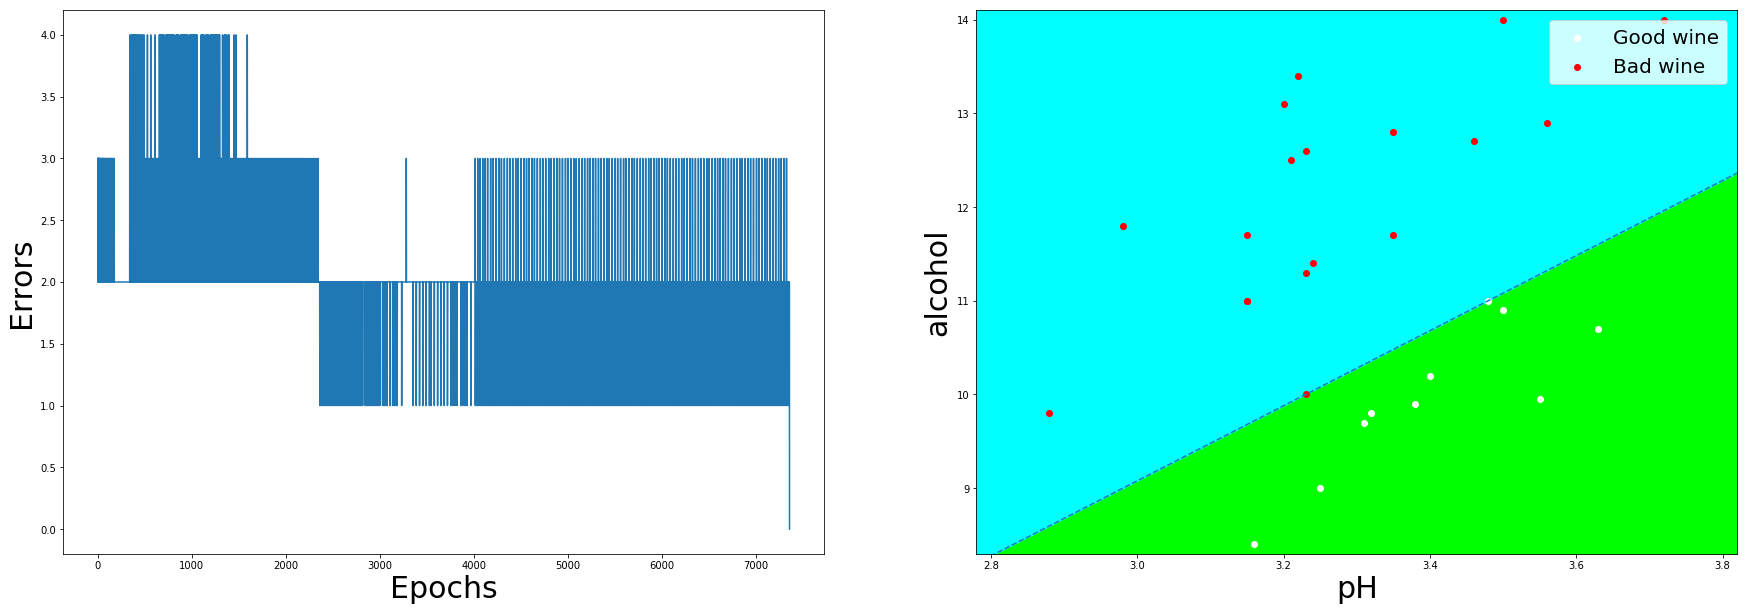

In [49]:
plot_performance(training_result, 
                 pd.concat([training_df, wine_data["quality"]], axis=1, sort=False), 
                 good_threshold, 
                 bad_threshold, 
                 epoch=-1, 
                 save_plot=False)

# V.3 My fair ADALINE

In [136]:
good_threshold = 7
bad_threshold = 4

wine_data_adaline, y_adaline = filter_wine_data(df_red, good_threshold, bad_threshold)

X_adaline = wine_data_adaline[["pH", "alcohol"]]
correct_df_adaline.shape

(280, 1)

In [196]:
class Adaline:
    def __init__(self):
        self.weights = None
        self.bias = None
        
        # correct weights
        # {'pH': -0.15363754053207296, 'alcohol': 0.035287834173735856}
        
        # correct bias
        # 0.1454937052212618

    def net_input(self, row):
        z = self.bias
        for index_w, weight in self.weights.items():
            z += row[index_w] * weight
        return z

    def activation_function(self, row):
        z = self.net_input(row)
        return z, 1.0 if z >= 0 else -1.0

    def train(self, train_df, correct_df, l_rate, epochs):
        self.train_df = train_df
        self.correct_df = correct_df
        self.weights = {key: random.uniform(-1, 1) for key in train_df.columns}
        self.bias = random.uniform(-1, 1)
        result = []
        epoch = 0

        while epoch < epochs or not epochs:
            tmp = {key: 0.0 for key in train_df.columns}
            sum_error = 0.0
            cost = 0.0
            
            for index, row in train_df.iterrows():
                output, prediction = self.activation_function(row)
                error = correct_df.loc[index].item() - prediction
                sum_error += error
                cost += 1./2 * (error ** 2)
                for index_w, weight in self.weights.items():
                    tmp[index_w] += error * l_rate * row[index_w]
                
            self.bias += l_rate * sum_error
            self.weights = {key: self.weights[key] + tmp[key] for key in train_df.columns}
            
            result.append((epoch, cost, list(self.weights.values()), self.bias))
            print("\rEpoch: {0}, cost: {1}".format(epoch, cost), end="")
            if cost == 0 and not epochs:
                break
            epoch += 1
        print()
        self.performance = result
        return result
    
    def check(self, test_df, correct_df):
        correct = 0
        n_errors = 0
        
        wrong = []
        
        for index, row in test_df.iterrows():
            output, prediction = self.activation_function(row)
            error = prediction - correct_df.loc[index].item()
            
            if error:
                wrong.append(row)
            
            n_errors = n_errors if not error else n_errors + 1
            correct = correct if error else correct + 1
        return correct, n_errors, wrong
    
    def plot(self, epoch=-1, save_plot=False):
        fig, axes = plt.subplots(1, 2, figsize=(30, 10))
        epoch = -1 if epoch < 0 or epoch >= len(self.performance) else epoch

        # first plot
        epochs = [row[0] for row in self.performance]
        errors = [row[1] for row in self.performance]
        axes[0].plot(epochs, errors)
        axes[0].set_xlabel("Epochs", fontsize=30)
        axes[0].set_ylabel("Errors", fontsize=30)

        # second plot
        columns = self.train_df.columns
        first_class = self.train_df[self.correct_df["class"] == 1.0]
        second_class = self.train_df[self.correct_df["class"] == -1.0]
        
        min_x = self.train_df[columns[0]].min() - 0.1
        max_x = self.train_df[columns[0]].max() + 0.1
        min_y = self.train_df[columns[1]].min() - 0.1
        max_y = self.train_df[columns[1]].max() + 0.1
        
        boundary_min = ((self.weights[columns[0]] * min_x + self.bias) / self.weights[columns[1]]) * -1
        boundary_max = ((self.weights[columns[0]] * max_x + self.bias) / self.weights[columns[1]]) * -1

        axes[1].plot([min_x, max_x], [boundary_min, boundary_max], linestyle='--')
        axes[1].fill_between([min_x, max_x], [boundary_min, boundary_max], min_y, color="#00FF00")
        axes[1].fill_between([min_x, max_x], [boundary_min, boundary_max], max_y, color="#00FFFF")
        
        axes[1].scatter(first_class[columns[0]], first_class[columns[1]], c="#FFFFFF", label="Class 1")
        axes[1].scatter(second_class[columns[0]], second_class[columns[1]], c="#FF0000", label="Class 2")
#         axes[1].scatter(good_wine_df[good_wine_df.columns[0]], good_wine_df[good_wine_df.columns[1]], c="#FFFFFF", label='Good wine')
#         axes[1].scatter(bad_wine_df[bad_wine_df.columns[0]], bad_wine_df[bad_wine_df.columns[1]], c="#FF0000", label="Bad wine")
        axes[1].set_xlabel(columns[0], fontsize=30)
        axes[1].set_ylabel(columns[1], fontsize=30)
        axes[1].legend(prop={'size': 20})
        plt.xlim(min_x, max_x)
        plt.ylim(min_y, max_y)
        if save_plot:
            plt.savefig('plot_performance_adaline.png', bbox_inches='tight')

In [199]:
random.seed(5)
adaline = Adaline()


training_result_adaline = adaline.train(X_adaline, y_adaline, 0.0001, 5000)
check_adaline = adaline.check(training_df_adaline, correct_df_adaline)
print("Epochs:", len(training_result_adaline))
print("Correct:", check_adaline[0], "Wrong:", check_adaline[1])

Epoch: 4999, cost: 100.0
Epochs: 5000
Correct: 217 Wrong: 63


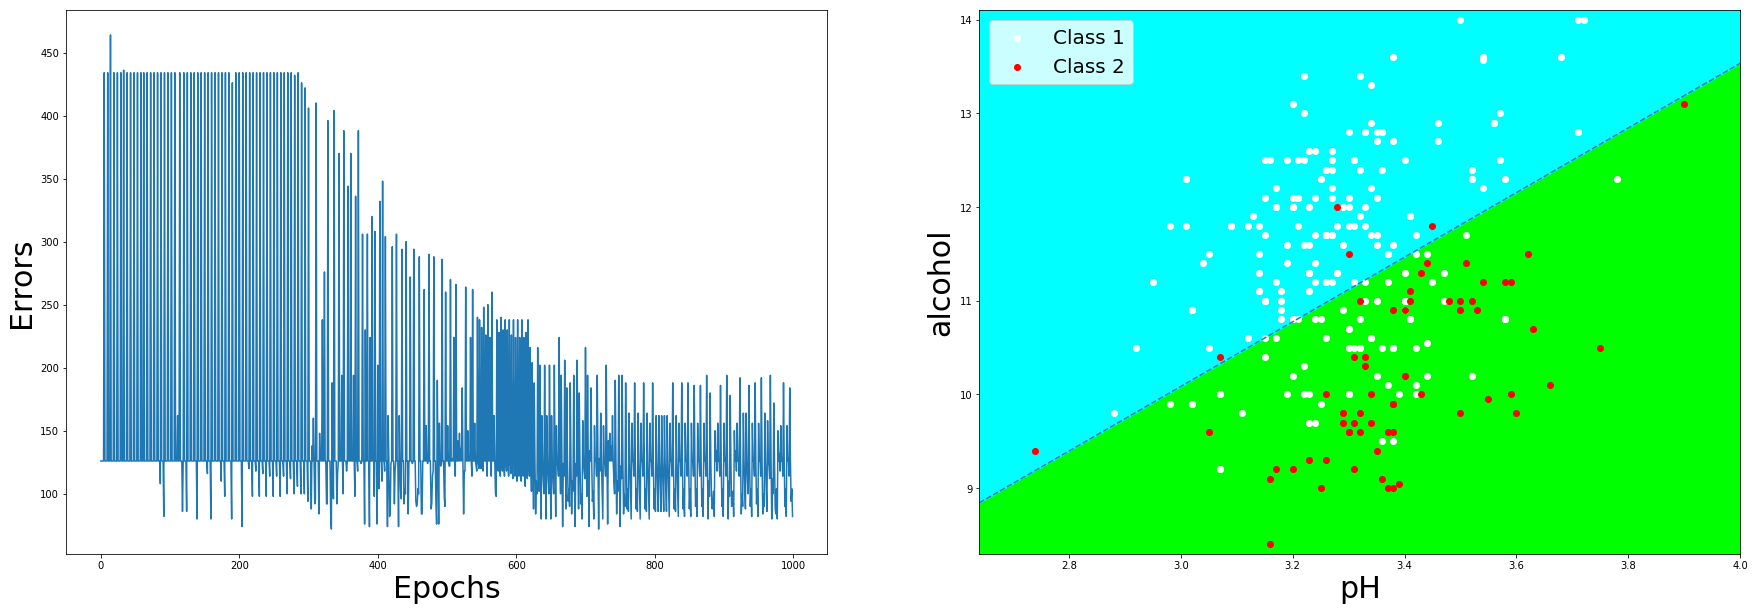

In [198]:
adaline.plot()

In [133]:
from sklearn import datasets

iris_datasets = datasets.load_iris()
X = pd.DataFrame(iris_datasets.data[:100, 2:]) # We only the two features: petal length and petal width
X.columns = ["A", "B"]
y = pd.DataFrame(iris_datasets.target[:100])
y.columns = ["class"]
y["class"] = y["class"].map({1.0: 1.0, 0.0: -1.0})

ada_iri_2 = Adaline()
iri_2_train_result = ada_iri_2.train(X, y, 0.01, 50)

ada_iri.plot()